[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UM-RMRS/raster_tools/blob/main/notebooks/general_module.ipynb)

# Raster Tools General Module
## This notebook demonstrates the functionality of the Raster Tools general module 
by John Hogland 4/19/2023

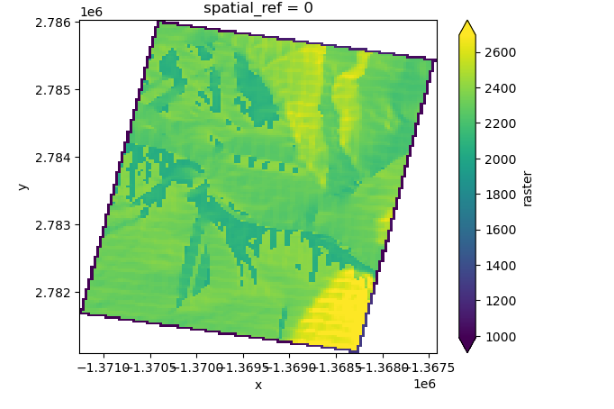

# Install software for Colab

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install --upgrade ipyleaflet
!pip install xarray_leaflet
!pip install raster_tools
!pip install py3dep
!pip install localtileserver

# The Process
In this notebook we download USGS 3dep products that are publicly available and use raster_tools to perform general processing. At each step in the notebook we will discuss various aspects of the data, processing techniques, and visualization. After completing this notebook you should be very familiar with how to use the general module.
## Steps
- 1. Create an area of interest (Missoula MT; 46.8721° N, 113.9940° W)
- 2. Use py3dep to download the dem for the area of interest
- 3. Create surface rasters and use for general module
- 4. Use General Module & visualize outputs

## Step 1: Create an area of interest (Missoula MT; 46.8721° N, 113.9940° W)
### Import various packages

In [ ]:
from raster_tools import Raster, general, surface, zonal

import geopandas as gpd
import numpy as np
import py3dep

from shapely.geometry import shape, Polygon

### Define area of interest (AOI) using the coordinates of Missoula MT

In [ ]:
loc = {"type": "Point", "coordinates": [-113.994, 46.8721]}

geom = shape(loc)
geom_buff = gpd.GeoSeries(
    geom.buffer(0.02), crs="EPSG:4326"
)  # buffer out 0.02 degrees to get an area
geom_buff.explore()  # visualize

## Step 2: Get DEM data from USGS wms servers
### Create a get_3dep_data function to download USGS data and return a Raster object

In [ ]:
def get_3dep_data(sgeo, srv="DEM", res=30, out_crs=None):
    """
    downloads 3dep data from a specified service and resolution and returns a raster object

    sgeo: object, polygon | mulipolygon | bounding box [minx, miny, maxx, maxy] used to extract data (WGS 84 - EPSG:4326)
    srv: string, name of the 3dep service
    res: int, spatial resolution
    out_crs: object, optional crs used to project geopandas dataframe to a differnt crs

    return: raster object
    """
    ar = py3dep.get_map(srv, sgeo, resolution=res).expand_dims({"band": 1})
    out_rs = Raster(ar)
    if not out_crs is None:
        out_rs = Raster(out_rs.xdata.rio.reproject(out_crs))

    return out_rs

### Use get_3dep_data to download DEM for AOI (resolution 30 m) and save the raster.

In [ ]:
elv = get_3dep_data(
    list(geom_buff.total_bounds), srv="DEM", res=30
)  # data are returned in lat lon (WGS 84) with height in meters
elv = elv.save("elv.tif")

## Step3: Create surface rasters from dem (slope, aspect, northing, easting, curvature, 3d area, etc )

In [ ]:
elv_p = Raster(elv.xdata.rio.reproject("EPSG:5070"))  # reproject to Albers
slp = surface.slope(
    elv_p, degrees=True
)  # slope: by default degrees to get percent set degrees flag to false
asp = surface.aspect(elv_p)  # aspect
curv = surface.curvature(elv_p)  # curvature
north = surface.northing(
    elv_p
)  # northing assumes elevation raster alternatively one could specify a aspect raster
east = surface.easting(
    elv_p
)  # easting assumes elevation raster alternatively one could specify a aspect raster
s3d = surface.surface_area_3d(
    elv_p
)  # calculates 3d surface area after Jense, 2004
hill = surface.hillshade(
    elv_p
)  # calculates hill shade; can specify azimuth and sun altitude
tpi = surface.tpi(
    elv_p, annulus_inner=0, annulus_outer=3
)  # calculates tpi given in and outer radii

## Step 4: Use general module with surface rasters to do the following:
- band_concat: creates a multi-band raster given a sequence of rasters (band_concat)
- aggregate: coarsens a raster's resolution and populates cell values based on a specified statistic
- local_stats: summarize cell values across bands
- model_predict_raster: creates a raster surface of modeled estimates
- remap_range: reclassifies rasters based on a range of values
- reclassify: reclassifies cell values given a dictionary
- regions: creates unique regions with a raster
- dilate: thickens raster features
- erode: thins raster features

### Stack surface rasters and visualize

In [ ]:
import matplotlib.pyplot as plt

elv_stack = general.band_concat(
    [elv_p, slp, asp, curv, north, east, s3d, hill, tpi]
)
display(elv_stack.xdata)

# plot the individual bands
f, axes = plt.subplots(figsize=(20, 20), ncols=3, nrows=3, tight_layout=True)

clms = [
    "Elevation",
    "Slope",
    "Aspect",
    "Curvature",
    "Northing",
    "Easting",
    "3d Surface Area",
    "Hill Shade",
    "TPI",
]
cramp = [
    plt.cm.terrain,
    plt.cm.gray,
    plt.cm.hsv,
    plt.cm.Spectral,
    plt.cm.gray,
    plt.cm.gray,
    plt.cm.Spectral,
    plt.cm.gray,
    plt.cm.gray,
]
for x in range(elv_stack.nbands):
    c = x % 3
    r = x // 3
    elv_stack.get_bands(x + 1).plot(ax=axes[r, c], robust=True, cmap=cramp[x])
    axes[r, c].set_title(clms[x], fontdict={"fontsize": 25, "fontweight": 3})

### Aggregate surface rasters and visualize (note cell size and grainy visualization)
- mean statistic
- 3 cells

In [ ]:
agg = general.aggregate(elv_stack, [3, 3], "mean")
display(agg.xdata)
print("Elevation stack resolution = " + str(elv_stack.resolution))
print("Agg stack resolution = " + str(agg.resolution))

# plot the individual bands
f, axes = plt.subplots(figsize=(20, 20), ncols=3, nrows=3, tight_layout=True)


for x in range(agg.nbands):
    c = x % 3
    r = x // 3
    agg.get_bands(x + 1).plot(ax=axes[r, c], robust=True, cmap=cramp[x])
    axes[r, c].set_title(
        "Agg " + clms[x], fontdict={"fontsize": 25, "fontweight": 3}
    )

### Calculate local stats (sum) and visualize

In [ ]:
locstats = general.local_stats(elv_stack, "sum")
display(locstats.xdata)
locstats.plot(robust=True)

### Create and predict a sklearn unsupervised classification (K-means)
#### Create a function to systematically sample locations

In [ ]:
def get_systematic_sample(geom_p, xdist, ydist):
    """
    produces a systematic sample with a random start

    parameters:

    geom_p = (poly) geometry of the polygon to be sampled
    xdist = (float) minimum distance (lon or easting) between
        sample locations
    ydist = (float) minimum distance (lat or northing) between
        sample locations
    area = (float) tile size in map units
    n = total number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    rx = np.random.random() * xdist / 2
    ry = np.random.random() * ydist / 2
    xs = np.arange(xmin + rx, xmax, xdist)
    ys = np.arange(ymin + ry, ymax, ydist)
    xv, yv = np.meshgrid(xs, ys)
    xv = xv.flatten()
    yv = yv.flatten()
    pnts = gpd.points_from_xy(x=xv, y=yv)
    pnts_check = pnts.intersects(geom_p.unary_union)
    pnts = pnts[pnts_check]
    dic = {"geometry": pnts}
    gdf = gpd.GeoDataFrame(dic, crs=geom_p.crs)
    return gdf

#### Create a sample to train the k-means classification

In [ ]:
import pandas as pd

xmin, ymin, xmax, ymax = elv_stack.bounds
geo = gpd.GeoSeries(
    Polygon(
        [[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin], [xmin, ymin]]
    ),
    crs=elv_stack.crs,
)
pnts = get_systematic_sample(geo, xdist=300, ydist=300)
pvls = zonal.extract_points_eager(pnts, elv_stack, "Metrics", axis=1).compute()
pnts_m = pd.concat([pnts, pvls], axis=1).dropna()
print(pnts_m.shape)
m1 = geo.explore(color="orange")
m2 = pnts_m.explore(m=m1, color="blue")
m2

#### Create the k-means sklearn model, use it to generate the new classified raster, plot the new raster

In [ ]:
from sklearn.cluster import KMeans

k = 10
fld_names = pnts_m.columns[1:]
X = pnts_m[fld_names]
mdl = KMeans(n_clusters=k, n_init="auto").fit(X.values)
km_rs = general.model_predict_raster(elv_stack, mdl, 1).astype("int32")
m1 = pnts_m.plot(color="black", zorder=1)
km_rs.plot(ax=m1, robust=True, zorder=0)

### Use the same model to predict sample values

In [ ]:
from raster_tools import Vector

print("create vector")
vc = Vector(pnts_m)
print("calculating fields")
t = general.model_predict_vector(vc, mdl, fld_names, "label")
print("showing field values")
t.data.compute()

### Remap a raster using value ranges

In [ ]:
rmap_rs = general.remap_range(
    elv_p, [(0, 1000, 1), (1000, 1100, 2), (1100, 3000, 3)]
)
rmap_rs.plot(robust=True)

### Reclassify a raster using a dictionary
- set unspecified values to null (unmapped_to_null=False)

In [ ]:
rclass_rs = general.reclassify(rmap_rs.astype("int32"), {1: 10, 2: 20}, True)
rclass_rs.plot(robust=True)

### Create regions given a classified raster

In [ ]:
reg_rs = general.regions(rclass_rs, 4)

reg_rs.plot()

### Dilate a raster
note how raster regions expand

In [ ]:
dil = general.dilate(reg_rs, 5)
dil.plot()

### Erode a raster
note how raster regions are trimmed 

In [ ]:
er = general.erode(reg_rs, 5)
er.plot()

# This ends the Raster Tools general module notebook
## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/blob/main/notebooks/README.md
## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html